# Data Science Salaries 2023

[Le dataset peut se trouver ici](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023?datasetId=3125926&sortBy=voteCount) et s'appuie sur le travail de [cette personne](https://www.kaggle.com/code/tumpanjawat/ds-salary-full-eda-geo-cluster-xgboost).

Nous utiliserons donc le même dataset pour rechercher la présence des clusters par rapport au salaire au sein de notre dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


### 1) Data quality

In [2]:
data = pd.read_csv('ds_salaries.csv')
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level',
})

data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
data['job_category'] = data['job_title'].apply(assign_broader_category)

data.head()

work_year        experience_level employment_type  \
0       2023                  Senior       Full-time   
1       2023  Mid/Intermediate level      Contractor   
2       2023  Mid/Intermediate level      Contractor   
3       2023                  Senior       Full-time   
4       2023                  Senior       Full-time   

                  job_title  salary salary_currency  salary_in_usd  \
0  Principal Data Scientist   80000             EUR          85847   
1               ML Engineer   30000             USD          30000   
2               ML Engineer   25500             USD          25500   
3            Data Scientist  175000             USD         175000   
4            Data Scientist  120000             USD         120000   

  employee_residence remote_ratio company_location company_size  \
0                 ES  Full-Remote               ES        LARGE   
1                 US  Full-Remote               US        SMALL   
2                 US  Full-Remote               US        SMALL   
3                 CA  Full-Remote               CA       MEDIUM   
4                 CA  Full-Remote               CA       MEDIUM   

       job_category  
0             Other  
1  Machine Learning  
2  Machine Learning  
3      Data Science  
4      Data Science

### 2) Analyse des données


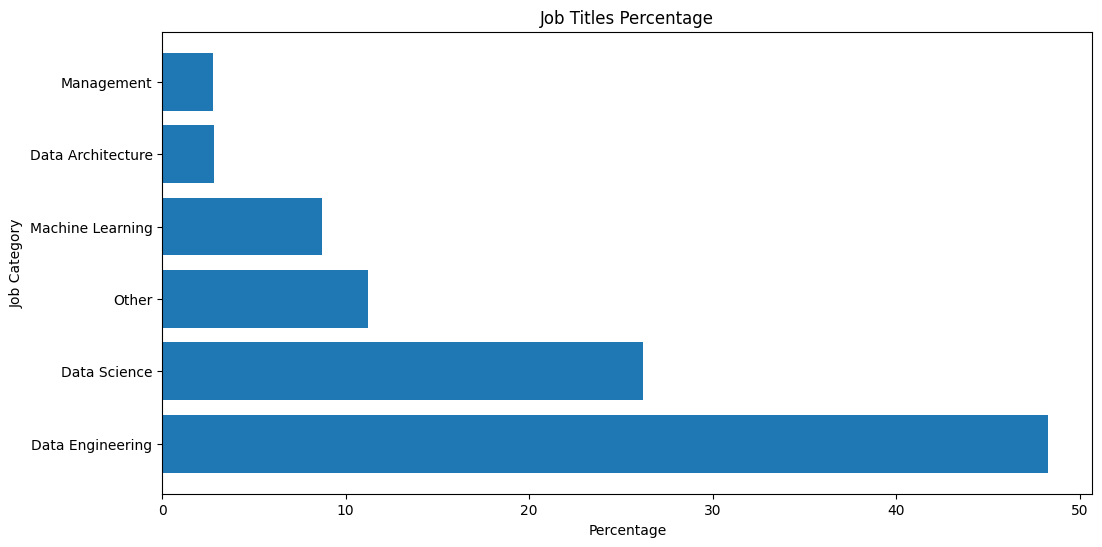

In [3]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

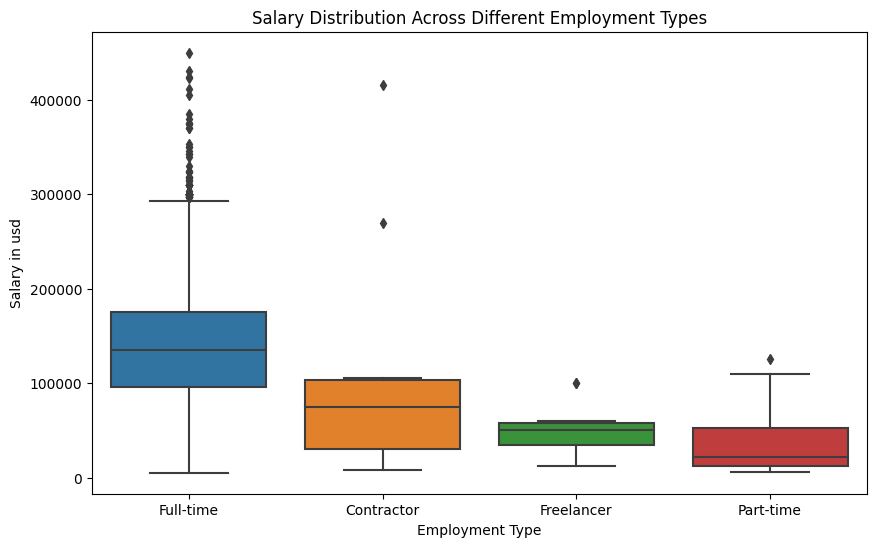

In [4]:
# Salary distribution across different employment types
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='employment_type', y='salary_in_usd')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Salary in usd')
plt.show()

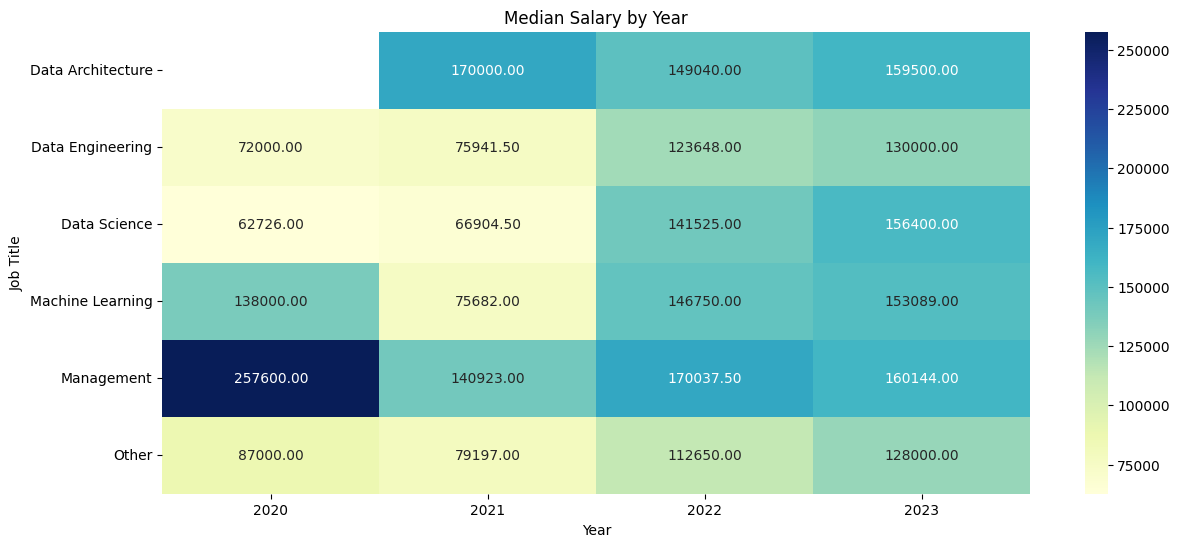

In [5]:
df = data.copy()

#  Median salary by job title
pivot_table = df.pivot_table(values='salary_in_usd', index='job_category', columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

### 3) Corrélation

In [6]:
categorical_columns = ['experience_level', 'employment_type', 'remote_ratio','company_size','job_category']
numerical_columns = ['salary_in_usd']

In [7]:
dummy_variables = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [8]:
df.head(5)

work_year        experience_level employment_type  \
0       2023                  Senior       Full-time   
1       2023  Mid/Intermediate level      Contractor   
2       2023  Mid/Intermediate level      Contractor   
3       2023                  Senior       Full-time   
4       2023                  Senior       Full-time   

                  job_title  salary salary_currency  salary_in_usd  \
0  Principal Data Scientist   80000             EUR          85847   
1               ML Engineer   30000             USD          30000   
2               ML Engineer   25500             USD          25500   
3            Data Scientist  175000             USD         175000   
4            Data Scientist  120000             USD         120000   

  employee_residence remote_ratio company_location company_size  \
0                 ES  Full-Remote               ES        LARGE   
1                 US  Full-Remote               US        SMALL   
2                 US  Full-Remote               US        SMALL   
3                 CA  Full-Remote               CA       MEDIUM   
4                 CA  Full-Remote               CA       MEDIUM   

       job_category  
0             Other  
1  Machine Learning  
2  Machine Learning  
3      Data Science  
4      Data Science

Pour le preprocessing de nos données, nous standardisons nos valeurs numériques afin d'avoir potentiellement des meilleurs résultats et les catégories sont encodées par le One-hot encoding afin que notre modèle puisse comprendre les données.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the numerical columns
scaled_numerical = scaler.fit_transform(df[numerical_columns])

# Convert the scaled numerical columns
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

# Drop the original numerical columns
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# Concatenate the dummy variables and scaled numerical columns
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)
processed_df = processed_df.drop(['work_year', 'salary', 'job_title', 'salary_currency',
                                  'salary', 'employee_residence', 'company_location'], axis=1)

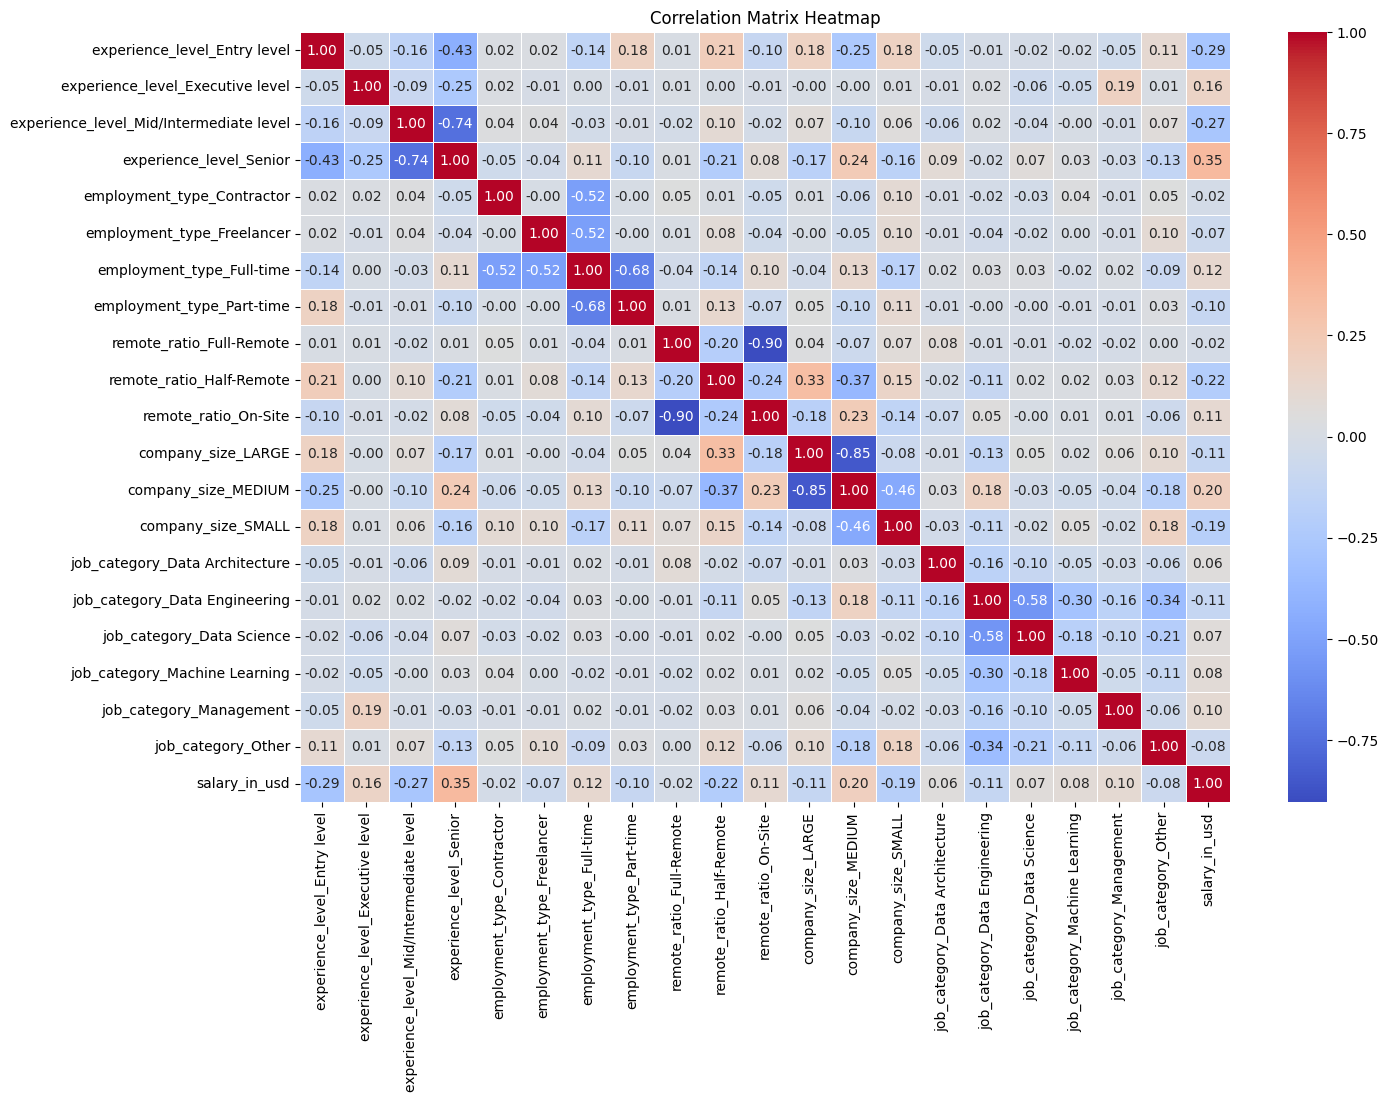

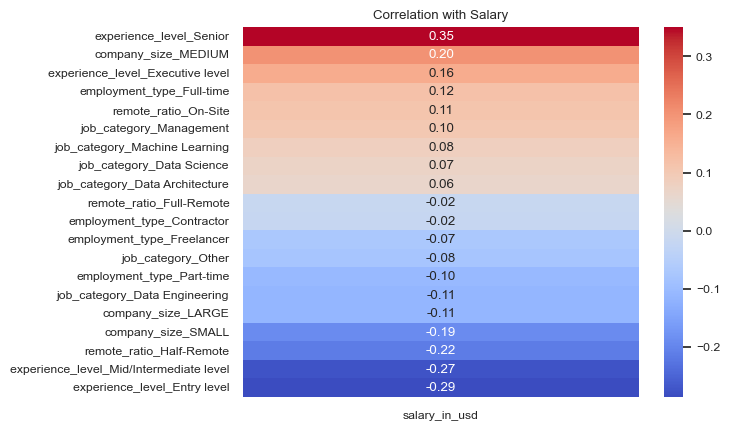

In [10]:
correlation_matrix = processed_df.corr()

#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

corr = processed_df.corr()
target_corr = corr['salary_in_usd'].drop('salary_in_usd')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

#Graph II
# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Salary')
plt.show()

### Recherche de cluster

Nous allons choisir les catégories les plus importantes pour ensuite rechercher la présence de clusters. La réduction de dimension va nous éclairer sur la présence de fortes relations entre les données et les catégories. La représentation de faible dimension conserve certaines propriétés significatives des données originales.

In [11]:
df = data.copy()
df = df.drop(['work_year','salary','salary_currency','job_title'], axis=1)
df.head()

experience_level employment_type  salary_in_usd employee_residence  \
0                  Senior       Full-time          85847                 ES   
1  Mid/Intermediate level      Contractor          30000                 US   
2  Mid/Intermediate level      Contractor          25500                 US   
3                  Senior       Full-time         175000                 CA   
4                  Senior       Full-time         120000                 CA   

  remote_ratio company_location company_size      job_category  
0  Full-Remote               ES        LARGE             Other  
1  Full-Remote               US        SMALL  Machine Learning  
2  Full-Remote               US        SMALL  Machine Learning  
3  Full-Remote               CA       MEDIUM      Data Science  
4  Full-Remote               CA       MEDIUM      Data Science

Pour les mêmes raison que précédemment, nous standardisons nos valeurs numériques afin d'avoir potentiellement des meilleurs résultats et les catégories sont encodées par le One-hot encoding afin que notre modèle puisse comprendre les données.

In [12]:
# Create a copy of the dataframe to not alter the original
df_preprocessed = df.copy()

# Preprocessing: Label encoding for categorical variables
le = LabelEncoder()
categorical_features = ['experience_level', 'employment_type', 'job_category', 'employee_residence', 'company_location', 'company_size', 'remote_ratio']
for feature in categorical_features:
    df_preprocessed[feature] = le.fit_transform(df[feature])

# Preprocessing: MinMax scaling for numerical/ratio variables
mm = MinMaxScaler()
numerical_features = ['salary_in_usd']
for feature in numerical_features:
    df_preprocessed[feature] = mm.fit_transform(df[feature].values.reshape(-1,1))

Nous utilisons [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (t-Distributed Stochastic Neighbor Embedding) pour la réduction de dimension afin de visulaiser un nombre élevé de dimension en 2D.

In [13]:
# Apply t-SNE with different perplexity and learning rate
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(df_preprocessed)
score = silhouette_score(tsne_results, df['salary_in_usd'])
print(f'Silhouette score : {score}')

# Plotly Interactive plot
df_tsne = pd.DataFrame(data = tsne_results, columns = ['Dim_1', 'Dim_2'])
df_tsne['salary_in_usd'] = df['salary_in_usd']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='salary_in_usd', title='t-SNE plot colored by Salary')
fig.show()

Silhouette score : -0.6738595366477966


Le graphique t-SNE montre les données en deux dimensions (Dim_1 et Dim_2). Ces dimensions n’ont pas de signification spécifique, mais elles sont construites de manière à préserver la structure des données de haute dimension dans l’espace 2D.

Les points sont dispersés sur le graphique, et il ne semble pas y avoir de séparation claire des grappes donc pas de structures fortes entre les données.

La barre de couleur à droite montre la plage de salaire de 100k à 500k. Il semble y avoir des points de toutes les couleurs sur le graphique, ce qui suggère qu’il n’y a pas de relation claire entre les labels et le salaire.

Le silhouette score varie de -1 à 1. Un score proche de 1 indique que les échantillons sont bien regroupés dans leur cluster et que les clusters sont bien séparés les uns des autres. Un score proche de 0 indique que les échantillons sont proches des limites des clusters et qu’il y a un chevauchement entre les clusters. Un score proche de -1 indique que les échantillons ont été mal assignés à leur cluster.

### Model tuning

On va essayer d'améliorer le modèle même si cela semble peu pertinent.

In [14]:
# Apply t-SNE with different perplexity and learning rate
perplexities = [5, 10, 100]
learning_rates = [10, 100, 500]
scores = []
for p in perplexities:
    for lr in learning_rates:
        tsne = TSNE(n_components=2, random_state=42, perplexity=p, learning_rate=lr)
        tsne_results = tsne.fit_transform(df_preprocessed)
        score = silhouette_score(tsne_results, df['salary_in_usd'])
        scores.append({'perplexity': p, 'learning_rate': lr, 'score': score})
        #df_tsne = pd.DataFrame(data=tsne_results, columns=['Dim_1', 'Dim_2'])
        #df_tsne['salary_in_usd'] = df['salary_in_usd']
        #fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='salary_in_usd', title=f't-SNE plot colored by Salary (Perplexity: {p}, Learning Rate: {lr})')
        #fig.show()

scores_df = pd.DataFrame(scores)
print(scores_df)

   perplexity  learning_rate     score
0           5             10 -0.604019
1           5            100 -0.606764
2           5            500 -0.605341
3          10             10 -0.623864
4          10            100 -0.628612
5          10            500 -0.633900
6         100             10 -0.678328
7         100            100 -0.675450
8         100            500 -0.680789


L’analyse en composantes principales (PCA) est une technique de réduction de dimension linéaire qui utilise une transformation orthogonale pour convertir un ensemble de variables corrélées en un ensemble de variables non corrélées appelées composantes principales. Les premières composantes principales capturent la plus grande partie de la variance dans les données et peuvent être utilisées pour visualiser les données dans un espace à faible dimension.

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_preprocessed)

# Plotly Interactive plot
df_pca = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
df_pca['salary_in_usd'] = df['salary_in_usd']
fig = px.scatter(df_pca, x='PC1', y='PC2', color='salary_in_usd', title='PCA plot colored by Salary')
fig.show()

score = silhouette_score(pca_results, df['salary_in_usd'])
print(f'Silhouette score : {score}')

Silhouette score : -0.6830875368521407


En conclusion, il n'y a pas de relation forte entre les données et le salaire.